# Training a Logistic Regression Model on encrypted training data

In [1]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

## Prepare the data
We now prepare the training and test data, the dataset was downloaded from Kaggle. [This dataset](https://www.kaggle.com/datasets/naveengowda16/logistic-regression-heart-disease-prediction) provides patients' information along with a 10-year risk of future coronary heart disease (CHD) as a label, and the goal is to build a model that can predict this 10-year CHD risk based on patients' information.

In [3]:
data = pd.read_csv("framingham.csv")
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
torch.random.manual_seed(73)
random.seed(73)

def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]
            
def heart_disease_data():    
    data = pd.read_csv("framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop(labels="TenYearCHD", axis='columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)

x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


## Training an Simple Logistic Regression Model on plain data

We will start by training a logistic regression model (without any encryption), which can be viewed as a single layer neural network with a single node.

In [5]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [6]:
n_features = x_train.shape[1]
model = LR(n_features)

# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)

# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

Distribution on plain data:


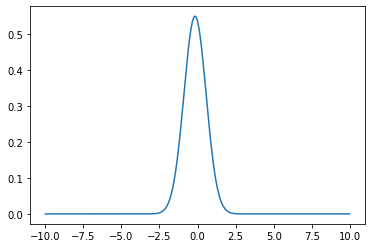

In [7]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
data = model.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

Most of the data falls into [-5, 5].

In [8]:
EPOCHS = 10

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

t_start = time()
model = train(model, optim, criterion, x_train, y_train)
t_end = time()
print(f"Plain model training took {int(t_end - t_start)} seconds")

Loss at epoch 1: 0.8504331707954407
Loss at epoch 2: 0.6863384246826172
Loss at epoch 3: 0.6358115673065186
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124349236488342
Loss at epoch 6: 0.6089244484901428
Loss at epoch 7: 0.6069258451461792
Loss at epoch 8: 0.6057038307189941
Loss at epoch 9: 0.6049202084541321
Loss at epoch 10: 0.604399561882019


In [9]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.697604775428772


We will be comparing accuracies over encrypted data against the plain_accuracy we got here.

## Training an Encrypted Logistic Regression Model on Encrypted Data

## TenSEAL Context
The TenSEALContext is a special object that holds different encryption keys and parameters for you, so that you only need to use a single object to make your encrypted computation instead of managing all the keys and the HE details. Basically, you will want to create a single TenSEALContext before doing your encrypted computation. Let's see how to create one !

In [2]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

### Model Encryption
From the input data to the parameter update, a ciphertext will need a multiplicative depth of 6, 1 for the dot product operation, 2 for the sigmoid approximation, and 3 for the backprobagation phase. With a scale of around 20 bits, we need 6 coefficients modulus with the same bit-size as the scale, plus the last coeffcient, which needs more bits, we are already out of the 4096 polynomial modulus degree (which requires < 109 total bit count of the coefficients modulus, if we consider 128-bit security), so we will use 8192. This will allow us to batch up to 4096 values in a single ciphertext, but we are far away from this limitation, so we shouldn't even think about it.

In [10]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [11]:
modeln = LR(n_features)
eelr = EncryptedLR(modeln)
eelr.encrypt(ctx_training)

### Data Encryption using the same key

In [12]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 11 seconds


We compare the distribution of `x.dot(weight) + bias` in both plain and encrypted domains. Since our sigmoid approximation is only good in the range [-5,5] , we want to have all its inputs in that range. In order to do this, we need to keep our logistic regression parameters as small as possible, so we apply regularization.

Distribution on encrypted data:


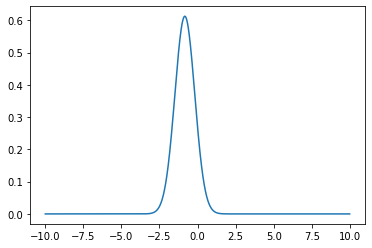

In [13]:
# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()


encrypted_out_distribution(eelr, enc_x_train)

Most of the data falls into [-5,5], the sigmoid approximation should be good enough!

We finally reached the last part, which is about training an encrypted logistic regression model on encrypted data! You can see that we decrypt the weights and re-encrypt them again after every epoch, this is necessary since after updating the weights at the end of the epoch, we can no longer use them to perform enough multiplications, so we need to get them back to the initial ciphertext level. In a real scenario, this would translate to sending the weights back to the secret-key holder for decryption and re-encryption. In that case, it will result in just a few Kilobytes of communication per epoch.

In [14]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")
t_startn = time()

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")

t_endn = time()
print(f"Encryption model training took {int(t_endn - t_startn)} seconds")
print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.523952066898346
Accuracy at epoch #1 is 0.6646706461906433
Accuracy at epoch #2 is 0.628742516040802
Accuracy at epoch #3 is 0.6556886434555054
Accuracy at epoch #4 is 0.6317365169525146
Accuracy at epoch #5 is 0.6467065811157227
Accuracy at epoch #6 is 0.6317365169525146
Accuracy at epoch #7 is 0.6347305178642273
Accuracy at epoch #8 is 0.6317365169525146
Accuracy at epoch #9 is 0.6317365169525146
Accuracy at epoch #10 is 0.6347305178642273
Encryption model training took 58 seconds

Average time per epoch: 57 seconds
Final accuracy is 0.6347305178642273
Difference between plain and encrypted accuracies: 0.06287425756454468
